In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # for plotting images, spectra, and metrics
from scipy.fft import fft2, fftshift  # for frequency-domain transforms

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

import shutil  # only if you need to move/copy datasets


In [2]:
# Base path to your dataset
BASE_PATH = '/cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake'

train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

# Check paths
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Training directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/train
Validation directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/valid
Test directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/test


In [3]:
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=16,
    image_size=(128, 128)  # matches your FFT preprocessing
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=16,
    image_size=(128, 128)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,  # usually don't shuffle test data
    batch_size=16,
    image_size=(128, 128)
)

Found 100001 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.


In [4]:
def standardize_image(image, label):
    """Normalizes an RGB image's pixel values to [0, 1]."""
    # Normalize the pixel values of all three RGB channels
    image = image / 255.0 
    
    return image, label

In [5]:
# Use AUTOTUNE to allow TensorFlow to find the best parallel settings
AUTOTUNE = tf.data.AUTOTUNE

# Apply the standardization function to each dataset
train_std = train_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_std = val_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
test_std = test_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)

# Configure datasets for optimal performance
train_std = train_std.cache().prefetch(buffer_size=AUTOTUNE)
val_std = val_std.cache().prefetch(buffer_size=AUTOTUNE)
test_std = test_std.cache().prefetch(buffer_size=AUTOTUNE)

print("Standardization applied successfully.")

Standardization applied successfully.


In [6]:
def transform_to_fft(images):
    """
    Takes a batch of standardized RGB images and returns their averaged 
    2D log-magnitude spectra.
    """
    fft_images = []
    for img in images.numpy(): # img shape is (128, 128, 3)
        
        # Perform FFT on each channel and get the magnitude spectrum
        r_fft = np.log(np.abs(fftshift(fft2(img[:,:,0]))) + 1)
        g_fft = np.log(np.abs(fftshift(fft2(img[:,:,1]))) + 1)
        b_fft = np.log(np.abs(fftshift(fft2(img[:,:,2]))) + 1)
        
        # Average the three spectra together
        magnitude_spectrum = (r_fft + g_fft + b_fft) / 3.0
        
        # Add the channel dimension back for consistency with the rest of the pipeline
        fft_images.append(np.expand_dims(magnitude_spectrum, axis=-1))
        
    return np.array(fft_images, dtype=np.float32)

# The fft_wrapper stays the same
def fft_wrapper(image, label):
    """A TensorFlow wrapper for the FFT function."""
    fft_image = tf.py_function(
        func=transform_to_fft,
        inp=[image],
        Tout=tf.float32
    )
    fft_image.set_shape([None, 128, 128, 1])
    return fft_image, label

In [7]:
def azimuthal_average(spectrum):
    """Calculates the azimuthally averaged 1D profile of a 2D spectrum."""
    center_y, center_x = np.array(spectrum.shape) // 2
    y, x = np.indices(spectrum.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_profile

def process_to_1d_profile(images_fft):
    """Takes a batch of 2D spectra and returns their 1D profiles."""
    profiles = []
    for spectrum in images_fft.numpy():
        profile = azimuthal_average(np.squeeze(spectrum, axis=-1))

        # Pad or truncate the profile to a fixed length for the model.
        fixed_length = 91
        if len(profile) < fixed_length:
            profile = np.pad(profile, (0, fixed_length - len(profile)))
        else:
            profile = profile[:fixed_length]
        profiles.append(profile)
    return np.array(profiles, dtype=np.float32)

def profile_wrapper(image_fft, label):
    """TensorFlow wrapper for the 1D profile function."""
    profile = tf.py_function(
        func=process_to_1d_profile,
        inp=[image_fft],
        Tout=tf.float32
    )
    profile.set_shape([None, 91])
    return profile, label

\n--- Verifying a batch of standardized images ---
Shape of image batch: (16, 128, 128, 3)
Minimum pixel value: 0.0
Maximum pixel value: 1.0


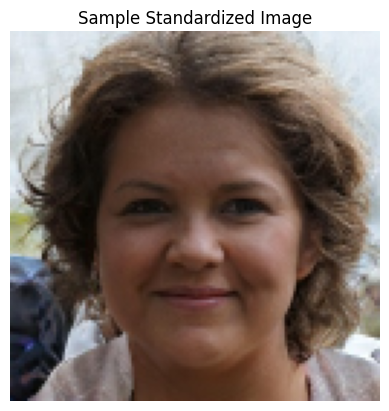

In [8]:
for images, labels in train_std.take(1):
    print("\\n--- Verifying a batch of standardized images ---")
    

    print("Shape of image batch:", images.shape) 
    
    # Check the data range: Values should be between 0 and 1
    print("Minimum pixel value:", tf.reduce_min(images).numpy())
    print("Maximum pixel value:", tf.reduce_max(images).numpy())
    
    # Display the first image in the batch
    plt.imshow(images[0], cmap='gray')
    plt.title("Sample Standardized Image")
    plt.axis('off')
    plt.show()

In [9]:
train_processed = train_std.map(fft_wrapper).map(profile_wrapper).cache().prefetch(buffer_size=AUTOTUNE)
val_processed = val_std.map(fft_wrapper).map(profile_wrapper).cache().prefetch(buffer_size=AUTOTUNE)


# 1. Define the MLP model architecture (without Dropout)
model = Sequential([
    # Input layer for our 1D frequency profiles
    Dense(128, activation='relu', input_shape=(91,)),
    Dense(64, activation='relu'),
    # Output layer for binary classification
    Dense(1, activation='sigmoid') 
])

# 2. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)

# Print a summary of the model
model.summary()


# 3. Train the model on the FULL processed datasets
print("\\n--- Starting Training on Full Dataset ---")
history = model.fit(
    train_processed,
    validation_data=val_processed,
    epochs=1  # Train for more epochs on the full dataset
)

/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,097 (78.50 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 0 (0.00 B)

\n--- Starting Training on Full Dataset ---


I0000 00:00:1760559024.050811  183530 service.cc:146] XLA service 0x7f563c00a720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760559024.050843  183530 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


  10/6251 ━━━━━━━━━━━━━━━━━━━━ 2:07 20ms/step - accuracy: 0.5430 - loss: 0.7416

I0000 00:00:1760559024.925638  183530 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6251/6251 ━━━━━━━━━━━━━━━━━━━━ 105s 17ms/step - accuracy: 0.5526 - loss: 0.6873 - val_accuracy: 0.5849 - val_loss: 0.6741


In [10]:
# Print the final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Print all accuracy values to see the training progression
print("\nTraining accuracy per epoch:")
for epoch, acc in enumerate(history.history['accuracy'], 1):
    print(f"Epoch {epoch}: {acc:.4f}")
    
print("\nValidation accuracy per epoch:")
for epoch, acc in enumerate(history.history['val_accuracy'], 1):
    print(f"Epoch {epoch}: {acc:.4f}")

Final Training Accuracy: 0.5647
Final Validation Accuracy: 0.5849

Training accuracy per epoch:
Epoch 1: 0.5647

Validation accuracy per epoch:
Epoch 1: 0.5849


In [11]:
def transform_to_fft(images):
    """
    Takes a batch of standardized RGB images and returns a 3-channel 
    2D log-magnitude spectrum.
    """
    fft_images = []
    for img in images.numpy(): # img shape is (128, 128, 3)
        
        # Perform FFT on each of the R, G, B channels
        r_fft = np.log(np.abs(fftshift(fft2(img[:,:,0]))) + 1)
        g_fft = np.log(np.abs(fftshift(fft2(img[:,:,1]))) + 1)
        b_fft = np.log(np.abs(fftshift(fft2(img[:,:,2]))) + 1)
        
        # Stack the three spectra along the channel axis to create a 3-channel image
        magnitude_spectrum = np.stack([r_fft, g_fft, b_fft], axis=-1)
        
        fft_images.append(magnitude_spectrum)
        
    return np.array(fft_images, dtype=np.float32)

# UPDATE the fft_wrapper to set the correct 3-channel shape
def fft_wrapper(image, label):
    """A TensorFlow wrapper for the FFT function."""
    fft_image = tf.py_function(
        func=transform_to_fft,
        inp=[image],
        Tout=tf.float32
    )
    # This now correctly sets the shape to 3 channels for the CNN
    fft_image.set_shape([None, 128, 128, 3]) 
    return fft_image, label

In [12]:
def azimuthal_average(spectrum):
    """Calculates the azimuthally averaged 1D profile of a 2D spectrum."""
    center_y, center_x = np.array(spectrum.shape) // 2
    y, x = np.indices(spectrum.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_profile

def process_to_1d_profile(images_fft):
    """Takes a batch of 2D spectra and returns their 1D profiles."""
    profiles = []
    for spectrum in images_fft.numpy():
        profile = azimuthal_average(np.squeeze(spectrum, axis=-1))

        # Pad or truncate the profile to a fixed length for the model.
        fixed_length = 91
        if len(profile) < fixed_length:
            profile = np.pad(profile, (0, fixed_length - len(profile)))
        else:
            profile = profile[:fixed_length]
        profiles.append(profile)
    return np.array(profiles, dtype=np.float32)

def profile_wrapper(image_fft, label):
    """TensorFlow wrapper for the 1D profile function."""
    profile = tf.py_function(
        func=process_to_1d_profile,
        inp=[image_fft],
        Tout=tf.float32
    )
    profile.set_shape([None, 91])
    return profile, label

In [13]:
from tensorflow.keras.layers import Normalization, Conv2D, MaxPooling2D, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Prepare the FFT datasets ---
print("--- Preparing FFT Data for CNN ---")
train_fft = train_dataset.map(standardize_image).map(fft_wrapper).cache().prefetch(buffer_size=AUTOTUNE)
val_fft = val_dataset.map(standardize_image).map(fft_wrapper).cache().prefetch(buffer_size=AUTOTUNE)

# --- 2. Create and adapt a Normalization layer ---
normalizer = Normalization(input_shape=(128, 128, 3)) 
normalizer.adapt(train_fft.map(lambda x, y: x))

# --- 3. Define the new, normalized CNN model ---
cnn_model = Sequential([
    normalizer,
    
    RandomFlip('horizontal'),
    
    Conv2D(32, (3, 3), activation='relu'), # No input_shape needed here
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# --- 4. Compile the model ---
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- 5. Create the EarlyStopping callback ---
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- 6. Train the model ---
print("\\n--- Starting Final CNN Model Training with Early Stopping ---")
cnn_history = cnn_model.fit(
    train_fft,
    validation_data=val_fft,
    epochs=50, 
    callbacks=[early_stopping]
)

--- Preparing FFT Data for CNN ---


/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


\n--- Starting Final CNN Model Training with Early Stopping ---
Epoch 1/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.5002 - loss: 0.7193 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5003 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/50
6251/6251 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932


ValueError: x and y must have same first dimension, but have shapes (19,) and (7,)

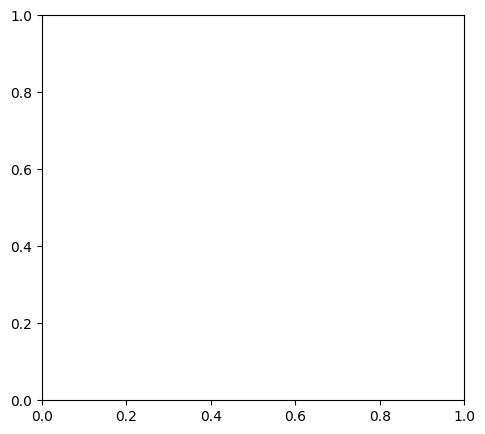

In [14]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
epochs_range = range(19)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Prepare the full test dataset with the FFT
test_fft = test_dataset.map(standardize_image).map(fft_wrapper).cache().prefetch(buffer_size=AUTOTUNE)

# Evaluate your new, trained CNN model
loss, accuracy = cnn_model_v3.evaluate(test_fft)

print(f"\\nFinal Test Accuracy: {accuracy:.4f}")